In [1]:
#For data loading and manipulation
import numpy as np
import pandas as pd

#For data visulisation
%matplotlib inline
import matplotlib.pyplot as plt
#pip install plotly
import plotly.express as px
import plotly as py
#pip install seaborn
import seaborn as sns
#For preprocssing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk import PorterStemmer,WordNetLemmatizer,wordpunct_tokenize,word_tokenize
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

#For Modelling
#pip install xgboost
#pip install lightgbm
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F


#For performance metrics, data spliting
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix,f1_score,ConfusionMatrixDisplay,
                             precision_score,accuracy_score,
                             recall_score,matthews_corrcoef,precision_recall_curve)

#For Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Utilities
import warnings
warnings.filterwarnings('ignore')
import random
import os
import re

In [2]:
#Assert train.csv and test.csv are in working directory
train_dir = (os.getcwd() +'/train.csv' if 'train.csv' in os.listdir() else print('training set not in working directory'))
test_dir = (os.getcwd() +'/test.csv' if 'test.csv' in os.listdir() else print('testing set not in working directory'))

#Load datasets
df_train = pd.read_csv(train_dir)
df_test = pd.read_csv(test_dir)

In [3]:
class preprocesser:
    """
    How to use:
    Initialize preprocesser e.g. prep = preporcesser()
    Obtain X,y for training and validation set using only the clean function e.g. X_train,X_val,y_train,y_val = prep.clean(task = 'InformationTheory',size = 'sample',input = 'abstract',method = 2)
    """

    class LemmaTokenizer(object):
        def __init__(self):
            self.wnl = WordNetLemmatizer()

        def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


    class SteamTokenizer(object):
        def __init__(self):
            self.ps = PorterStemmer()

        def __call__(self, doc):
            return [self.ps.stem(t) for t in word_tokenize(doc)]
        
    def __init__(self):
        self.df = df_train
        self.lemma = self.LemmaTokenizer()
        self.steam  = self.SteamTokenizer()

        self.stem_vectorizer = TfidfVectorizer(
                                  tokenizer=self.steam)
        self.LemmaTokenizer = CountVectorizer(
            tokenizer=self.lemma
)

    def df_train_val_split(self, task, input, size):
        
        """
        task:Dependent variables can be choose from ['InformationTheory','ComputationalLinguistics','ComputerVision']

        input:independent variable that can be choose from ['title','abstract']

        size = select from ['full','sample'] to return either 10% or entire training set

        df_train_1k, df_val_1k: The first 1000 sample of the df_train set(900 inputs), and split 10% as validation set(100 inputs)

        df_train_all, df_val_all: The entire training data(112500 inputs) excluding 10% as validation set(12500 inputs)

        Return: X_train,X_val,y_train,y_val the training and validation value as list for both X and y variables
        """
        # Assert inputs meets function requirement
        assert input in [
            'title', 'abstract'], 'Please ensure input is choosen from title and abstract'
        assert task in ['InformationTheory', 'ComputationalLinguistics',
                        'ComputerVision'], 'Please ensure column name you wish to predict are correct'
        assert size in ['full', 'sample'], 'choose only full or sample dataset'

        if size == 'sample':
            df_1k = self.df.sample(1000).reset_index(drop=True)
            df_train_1k, df_val_1k = train_test_split(df_1k, test_size=.1)
            X_train = df_train_1k[input].tolist()
            X_val = df_val_1k[input].tolist()
            y_train = df_train_1k[task].tolist()
            y_val = df_val_1k[task].tolist()

        elif size == 'full':
            df_train_all, df_val_all = train_test_split(self.df, test_size=.1)
            X_train = df_train_all[input].tolist()
            X_val = df_val_all[input].tolist()
            y_train = df_train_all[task].tolist()
            y_val = df_val_all[task].tolist()
        return X_train, X_val, y_train, y_val


    def preprocess(self,text,method = 1):
        """
        text :raw text from dataset input
        method: int 1 or 2, refer to differetn preprocessing method
        Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
        Method 2: Text to be lower, remove special charaters,spaces and apply lemmatizer and countvectorizer
        """
        assert method in [1,2],'Please select 1 or 2 only'
        STOPWORDS = set(stopwords.words('english'))

        # Lower
        text = text.lower()
        # Remove Special characters
        text = re.sub(r'\n','',text)
        # Spacing and filters
        text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
        text = re.sub(' +', ' ', text)  # remove multiple spaces
        text = text.strip() 

        if method == 1:
            # Remove stopwords
            pattern = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*')
            text = pattern.sub('', text)
            # Remove words in paranthesis
            text = re.sub(r'\([^)]*\)', '', text)

        else:
            pass

        return text
    
    def clean(self,task,size,input,method):
        """
        Task,input,size = require argument for df_train_val_split
        method = require argument ofr preprocess
        """
        X_train, X_val, y_train, y_val = self.df_train_val_split(task,input,size)

        if method == 1:
            X_train = [self.preprocess(i,method =1 ) for i in X_train]
            X_train = self.stem_vectorizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,method =1) for i in X_val]
            X_val = self.stem_vectorizer.transform(X_val).astype(np.float64)
        elif method == 2:
            X_train = [self.preprocess(i,method =2 ) for i in X_train]
            X_train = self.LemmaTokenizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,method =2 ) for i in X_val]
            X_val = self.LemmaTokenizer.transform(X_val).astype(np.float64)
        y_train = np.asarray(y_train)
        y_val =np.asanyarray(y_val)
        return X_train,X_val,y_train,y_val


In [7]:
prep = preprocesser()
X_train,X_val,y_train,y_val = prep.clean(task = 'InformationTheory',size = 'sample',input = 'abstract',method = 2)

In [8]:
class training:
    """
    
    """
    def __init__(self):
        self.models = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': lgb.LGBMClassifier(verbose = -1),
    'BaggingClassifier': BaggingClassifier(),
    'CatBoostClassifier': CatBoostClassifier(verbose=-1)}
        
        self.param_grid =param_grid = {
        'AdaBoostClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'n_estimators': range(10, 500, 10),
            'algorithm': ['SAMME', 'SAMME.R']
        },
        'RandomForestClassifier': {
            'n_estimators': range(10, 500, 10),
            'criterion': ['gini', 'entropy'],
            'max_features': ['auto', 'sqrt', 'log2']
        },
        'DecisionTreeClassifier': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': range(1, 16, 2)
        },
        'XGBClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'n_estimators': range(10, 500, 10),
            'max_depth': range(1, 16, 2),
            'subsample': np.arange(0, 1, 0.1),
            'colsample_bytree': np.arange(0, 1, 0.1)
        },
        'LGBMClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'n_estimators': range(10, 500, 10),
            'max_depth': range(1, 16, 2),
            'subsample': np.arange(0, 1, 0.1),
            'colsample_bytree': np.arange(0, 1, 0.1),
            'feature_fraction':np.arange(0.1,1,0.1),
            'bagging_fraction':np.arange(0.1,1,0.1)
        },
        'BaggingClassifier': {
            'n_estimators': range(10, 500, 10),
            'max_samples': np.arange(0, 1, 0.1),
            'max_features': np.arange(0, 1, 0.1)
        },
        'CatBoostClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'depth': range(1, 16, 2),
            'max_leaves': [0, 64, 2],
            'l2_leaf_reg': [0, 10, 0.5],
            'subsample': np.arange(0, 1, 0.1)
        }}

    def model_selection(self,CV):
        cv_df = pd.DataFrame(index = range(CV *len(self.models)))
        entries = []
        for mod_name,model in self.models.items():
            accs = cross_val_score(model,X_train,y_train,scoring = 'accuracy',cv = CV)
            for cv_idx,acc in enumerate(accs):
                entries.append((mod_name,cv_idx,acc))
        cv_df  = pd.DataFrame(entries,columns=['model_name', 'fold_idx', 'accuracy'])
        best_model_name = cv_df.groupby('model_name')['accuracy'].mean().sort_values(ascending=False).index[0]
        print(f"The Most accuray model is {best_model_name}")
        return best_model_name
    
    def fine_tuning(self,CV,X,Y,X_val):
        best_model_name = self.model_selection(CV)
        randomized_scv = RandomizedSearchCV(
            estimator=self.models[best_model_name],
            param_distributions = self.param_grid[best_model_name],
            n_iter = 20,
            scoring= 'accuracy',
            cv = CV,
            random_state= 1,
            n_jobs = -1
        ).fit(X,Y)
        best_model = randomized_scv.best_estimator_
        best_model.fit(X,Y)
        y_pred = best_model.predict(X_val)
        return y_pred
    
    def draw_metric(self,CV,X,Y,X_val,y_val):
        y_pred = self.fine_tuning(CV,X,Y,X_val)
        print(f"The F1 Score for this setting is {f1_score(y_val,y_pred):.3f}")
        print(f"The recall for this setting is {recall_score(y_val,y_pred):.3f}")
        print(f"The Precision for this setting is {precision_score(y_val,y_pred):.3f}")
        print(f"The accuracy for this setting is {accuracy_score(y_val,y_pred):.3f}")
        cm = confusion_matrix(y_val,y_pred)
        fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
        ax1.imshow(cm,cmap = 'Spectral')
        ax1.set_title('Confusion Matrix')
        ax1.set_xlabel('Predicted Label')
        ax1.set_ylabel('True Label')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax1.text(j, i, str(cm[i, j]), ha='center', va='center')
        ax1.grid(False)
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
        ax2.fill_between(recall, precision)
        ax2.set_ylabel("Precision")
        ax2.set_xlabel("Recall")
        ax2.set_title("Precision-Recall curve")
        ax2.plot(recall,precision)
        plt.show()

Learning rate set to 0.008954
0:	learn: 0.6847587	total: 76.7ms	remaining: 1m 16s
600:	learn: 0.1019876	total: 9.87s	remaining: 6.55s
999:	learn: 0.0525532	total: 16.3s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6875758	total: 15.9ms	remaining: 15.9s
600:	learn: 0.1034781	total: 9.77s	remaining: 6.49s
999:	learn: 0.0542744	total: 16.3s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6888794	total: 16.1ms	remaining: 16.1s
600:	learn: 0.1040587	total: 9.9s	remaining: 6.57s
999:	learn: 0.0528364	total: 16.5s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6856043	total: 16ms	remaining: 16s
600:	learn: 0.1123020	total: 9.83s	remaining: 6.53s
999:	learn: 0.0568026	total: 16.4s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6852654	total: 16.2ms	remaining: 16.2s
600:	learn: 0.1119728	total: 9.9s	remaining: 6.58s
999:	learn: 0.0606571	total: 16.5s	remaining: 0us
The Most accuray model is LGBMClassifier
[LightGBM] [Warning] bagging_fraction is set=0.70

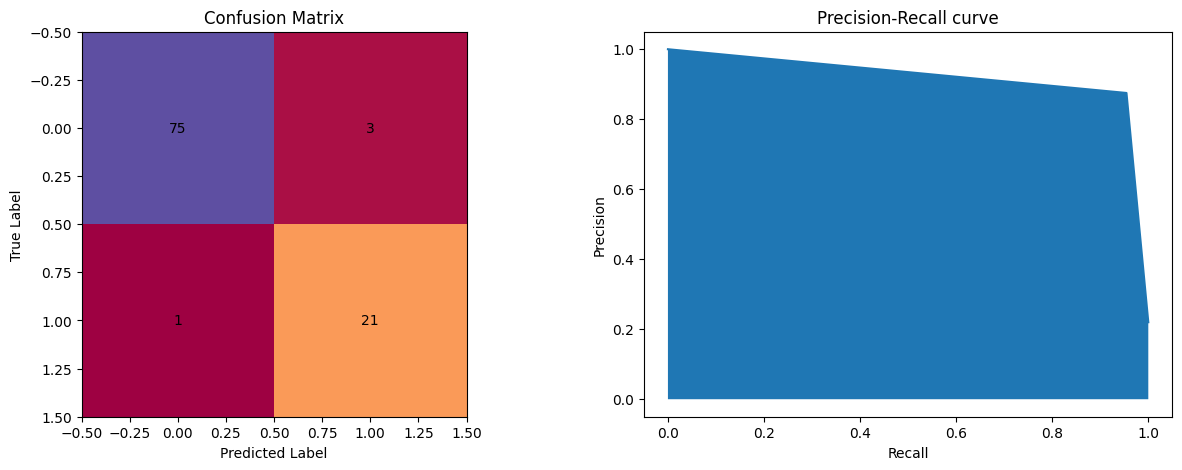

In [6]:
tra = training()
y_pred = tra.draw_metric(CV = 5,X = X_train,Y = y_train, X_val = X_val,y_val = y_val)

Learning rate set to 0.008954
0:	learn: 0.6858916	total: 14.7ms	remaining: 14.7s
600:	learn: 0.1260715	total: 7.81s	remaining: 5.19s
999:	learn: 0.0721125	total: 12.9s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6891603	total: 13.6ms	remaining: 13.5s
600:	learn: 0.1394249	total: 7.92s	remaining: 5.25s
999:	learn: 0.0798489	total: 13.1s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6878932	total: 12.6ms	remaining: 12.6s
600:	learn: 0.1337863	total: 7.86s	remaining: 5.22s
999:	learn: 0.0754548	total: 12.9s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6885713	total: 13ms	remaining: 12.9s
600:	learn: 0.1381472	total: 7.81s	remaining: 5.18s
999:	learn: 0.0787496	total: 13s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6889674	total: 12.8ms	remaining: 12.8s
600:	learn: 0.1186612	total: 7.79s	remaining: 5.17s
999:	learn: 0.0648690	total: 12.8s	remaining: 0us
The Most accuray model is LGBMClassifier
[LightGBM] [Warning] bagging_fraction is set=0.7

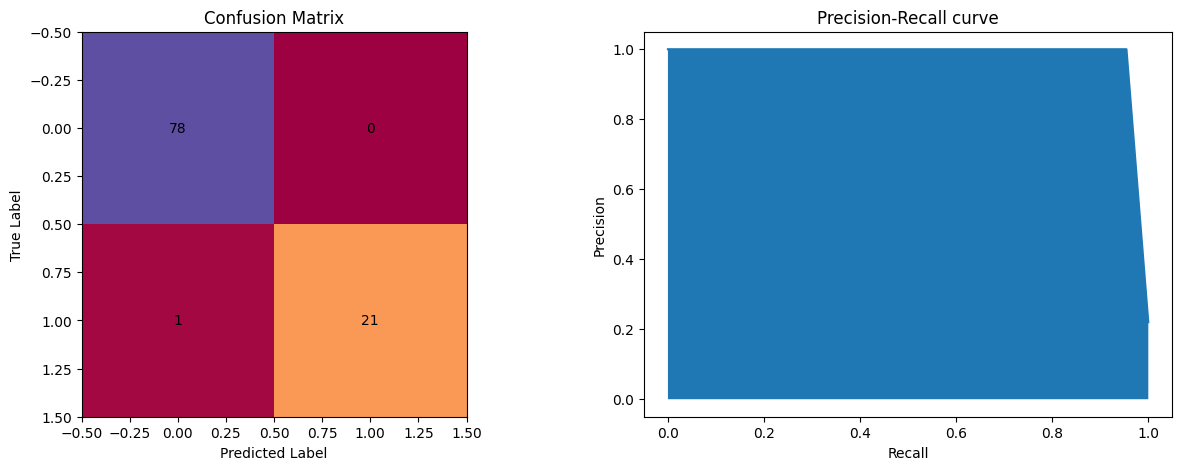

In [9]:
tra = training()
y_pred = tra.draw_metric(CV = 5,X = X_train,Y = y_train, X_val = X_val,y_val = y_val)

Learning rate set to 0.008954
0:	learn: 0.6892645	total: 2.61ms	remaining: 2.61s
600:	learn: 0.2555498	total: 1.53s	remaining: 1.01s
999:	learn: 0.1932038	total: 2.51s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6891298	total: 2.34ms	remaining: 2.34s
600:	learn: 0.2661384	total: 1.48s	remaining: 984ms
999:	learn: 0.2004558	total: 2.52s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6879756	total: 2.43ms	remaining: 2.42s
600:	learn: 0.2660870	total: 1.54s	remaining: 1.02s
999:	learn: 0.2056405	total: 2.52s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6889083	total: 2.16ms	remaining: 2.15s
600:	learn: 0.2553368	total: 1.49s	remaining: 990ms
999:	learn: 0.1917586	total: 2.51s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6885374	total: 2.19ms	remaining: 2.19s
600:	learn: 0.2716904	total: 1.52s	remaining: 1.01s
999:	learn: 0.2051945	total: 2.51s	remaining: 0us
The Most accuray model is RandomForestClassifier


/Users/hanli/miniforge3/envs/ds/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/hanli/miniforge3/envs/ds/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/hanli/miniforge3/envs/ds/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remo

The F1 Score for this setting is 0.765
The recall for this setting is 0.619
The Precision for this setting is 1.000
The accuracy for this setting is 0.920


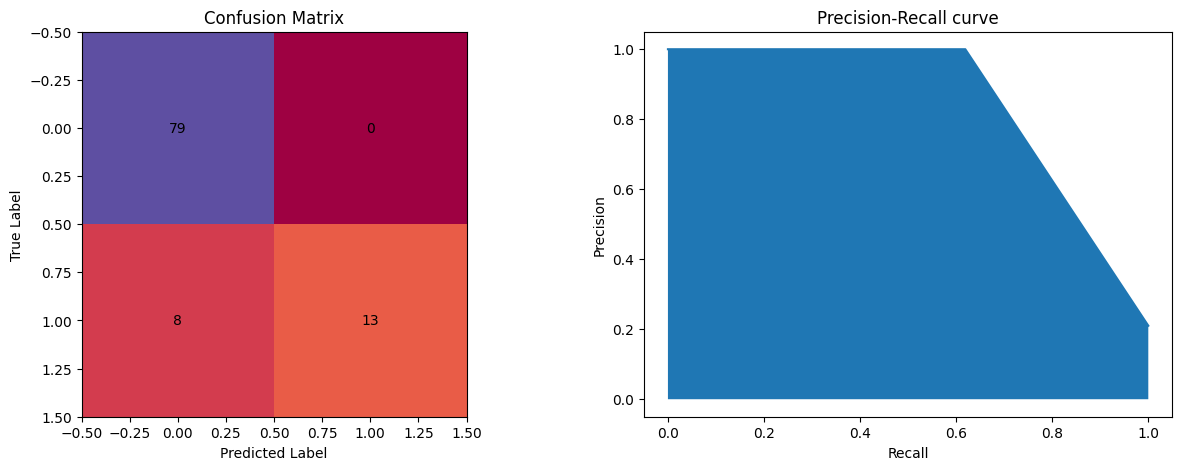

In [11]:
y_pred = tra.draw_metric(CV = 5,X = X_train,Y = y_train, X_val = X_val,y_val = y_val)

In [12]:
prep = preprocesser()
X_train,X_val,y_train,y_val = prep.clean(task = 'ComputerVision',size = 'full',input = 'abstract',method = 2)
y_pred = tra.draw_metric(CV = 5,X = X_train,Y = y_train, X_val = X_val,y_val = y_val)